# Customer Segmentation Using Clustering
**XYZ Marketings - Credit Card Customer Behavioral Analysis**

**Objective:** Develop a clustering model to segment credit card customers based on usage behavior for targeted marketing strategies (savings plans, loans, wealth management).

**Approach:** CRISP-DM methodology with multiple clustering algorithms, hyperparameter tuning, and comprehensive evaluation.

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# Evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('husl')

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Data Loading and Initial Assessment

In [ ]:
# Load data - update path for your environment
# For Google Colab: upload file or mount Google Drive
df = pd.read_csv('CustomerData.csv')

# Data overview
print(f"Dataset Shape: {df.shape[0]:,} customers × {df.shape[1]} features")
print(f"\nMissing Values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")
print(f"\nData Types:\n{df.dtypes.value_counts()}")

Dataset Shape: 8,950 customers × 18 features

Missing Values:
CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64

Data Types:
float64    14
int64       3
object      1
Name: count, dtype: int64


In [ ]:
# Statistical summary of key behavioral features
df.describe().T.style.format('{:.2f}').background_gradient(cmap='Blues', subset=['mean', 'std'])

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.00,1564.47,2081.53,0.00,128.28,873.39,2054.14,19043.14
BALANCE_FREQUENCY,8950.00,0.88,0.24,0.00,0.89,1.00,1.00,1.00
PURCHASES,8950.00,1003.20,2136.63,0.00,39.63,361.28,1110.13,49039.57
ONEOFF_PURCHASES,8950.00,592.44,1659.89,0.00,0.00,38.00,577.40,40761.25
INSTALLMENTS_PURCHASES,8950.00,411.07,904.34,0.00,0.00,89.00,468.64,22500.00
CASH_ADVANCE,8950.00,978.87,2097.16,0.00,0.00,0.00,1113.82,47137.21
PURCHASES_FREQUENCY,8950.00,0.49,0.40,0.00,0.08,0.50,0.92,1.00
ONEOFF_PURCHASES_FREQUENCY,8950.00,0.20,0.30,0.00,0.00,0.08,0.30,1.00
PURCHASES_INSTALLMENTS_FREQUENCY,8950.00,0.36,0.40,0.00,0.00,0.17,0.75,1.00
CASH_ADVANCE_FREQUENCY,8950.00,0.14,0.20,0.00,0.00,0.00,0.22,1.50


## 2. Data Preprocessing

**Strategy:**
- Handle missing values using median imputation (robust to outliers)
- Remove identifier column (CUST_ID)
- Apply RobustScaler to handle outliers in financial data

In [ ]:
# Preserve customer IDs for later mapping
customer_ids = df['CUST_ID'].copy()

# Drop identifier column for clustering
df_features = df.drop('CUST_ID', axis=1)

# Impute missing values with median (robust to outliers)
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(
    imputer.fit_transform(df_features),
    columns=df_features.columns
)

print(f"Missing values after imputation: {df_imputed.isnull().sum().sum()}")
print(f"Features for clustering: {df_imputed.shape[1]}")

Missing values after imputation: 0
Features for clustering: 17


In [ ]:
# Scale features using RobustScaler (handles outliers better than StandardScaler)
scaler = RobustScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_imputed),
    columns=df_imputed.columns
)

print("Scaling complete. Feature statistics (post-scaling):")
df_scaled.describe().loc[['mean', 'std', 'min', 'max']].T

Scaling complete. Feature statistics (post-scaling):


,mean,std,min,max
BALANCE,0.358848,1.080833,-0.453504,9.434627
BALANCE_FREQUENCY,-1.104565,2.132138,-9.000009,0.000000
PURCHASES,0.599652,1.995932,-0.337489,45.472693
ONEOFF_PURCHASES,0.960223,2.874738,-0.065812,70.528052
INSTALLMENTS_PURCHASES,0.687243,1.929718,-0.189912,47.821611
CASH_ADVANCE,0.878840,1.882855,0.000000,42.320270
PURCHASES_FREQUENCY,-0.011579,0.481645,-0.600000,0.600000
ONEOFF_PURCHASES_FREQUENCY,0.397082,0.994454,-0.277777,3.055557
PURCHASES_INSTALLMENTS_FREQUENCY,0.263694,0.529930,-0.222223,1.111111
CASH_ADVANCE_FREQUENCY,0.608150,0.900547,0.000000,6.750007


## 3. Exploratory Data Analysis

**Key Questions:**
1. How are customers distributed across spending and payment behaviors?
2. What correlations exist between features?
3. Are there natural groupings visible in the data?

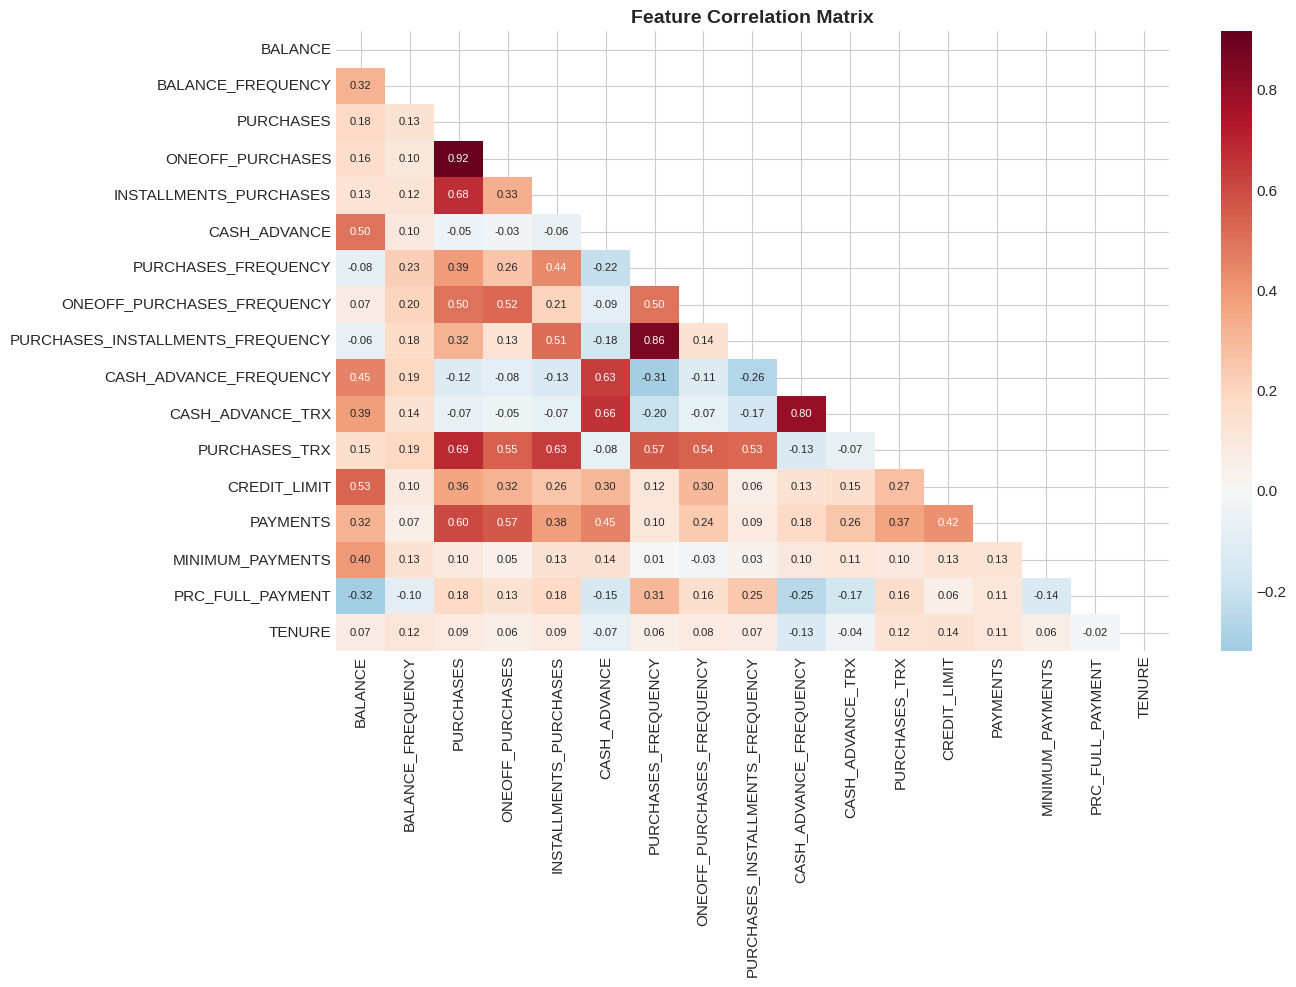

In [ ]:
# Feature correlation heatmap
fig, ax = plt.subplots(figsize=(14, 10))
correlation_matrix = df_imputed.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, ax=ax, annot_kws={'size': 8})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

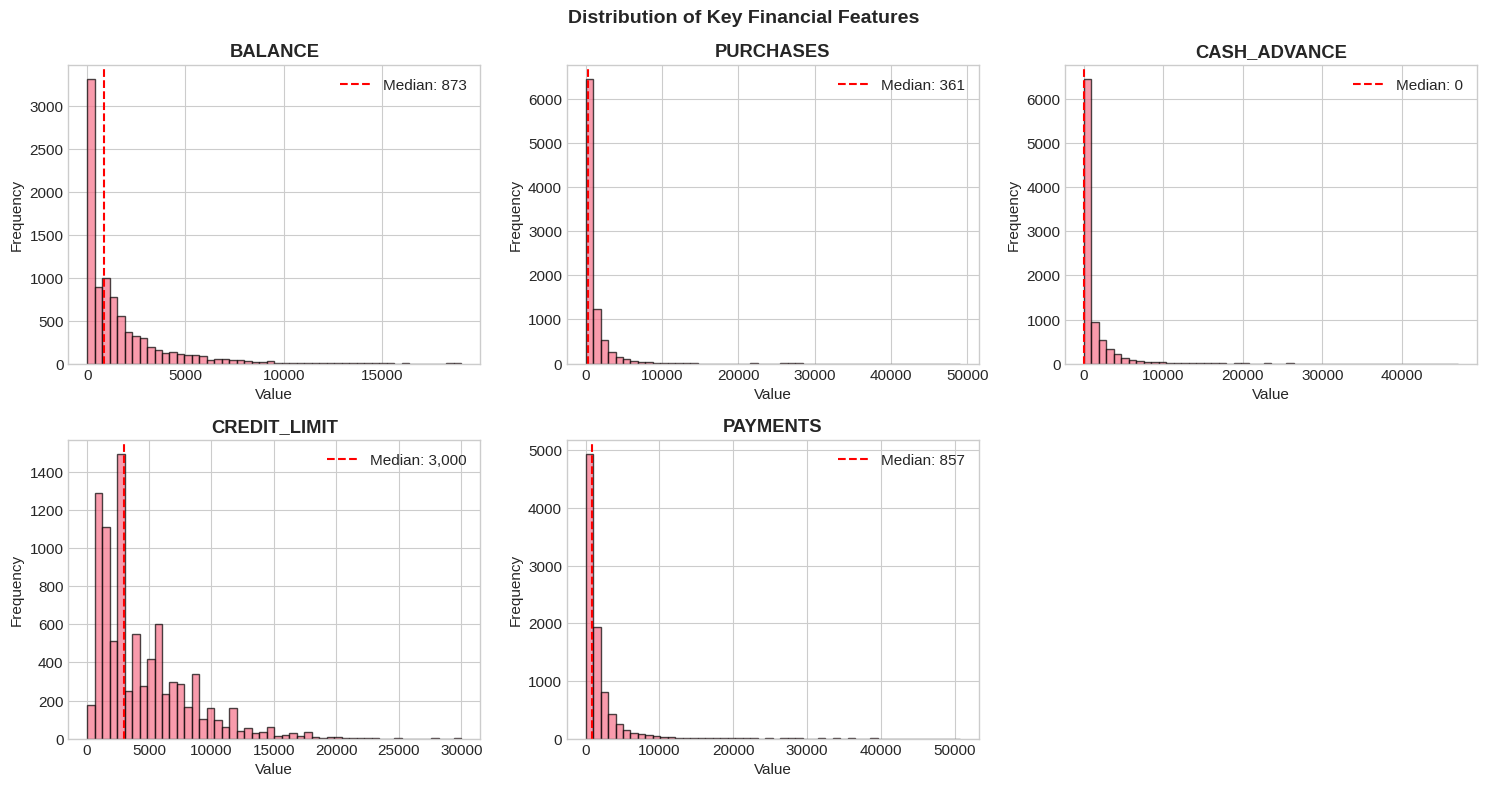

In [ ]:
# Distribution analysis of key behavioral features
key_features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    axes[i].hist(df_imputed[feature], bins=50, edgecolor='black', alpha=0.7)
    axes[i].axvline(df_imputed[feature].median(), color='red', linestyle='--',
                    label=f'Median: {df_imputed[feature].median():,.0f}')
    axes[i].set_title(feature, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

axes[-1].axis('off')
plt.suptitle('Distribution of Key Financial Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

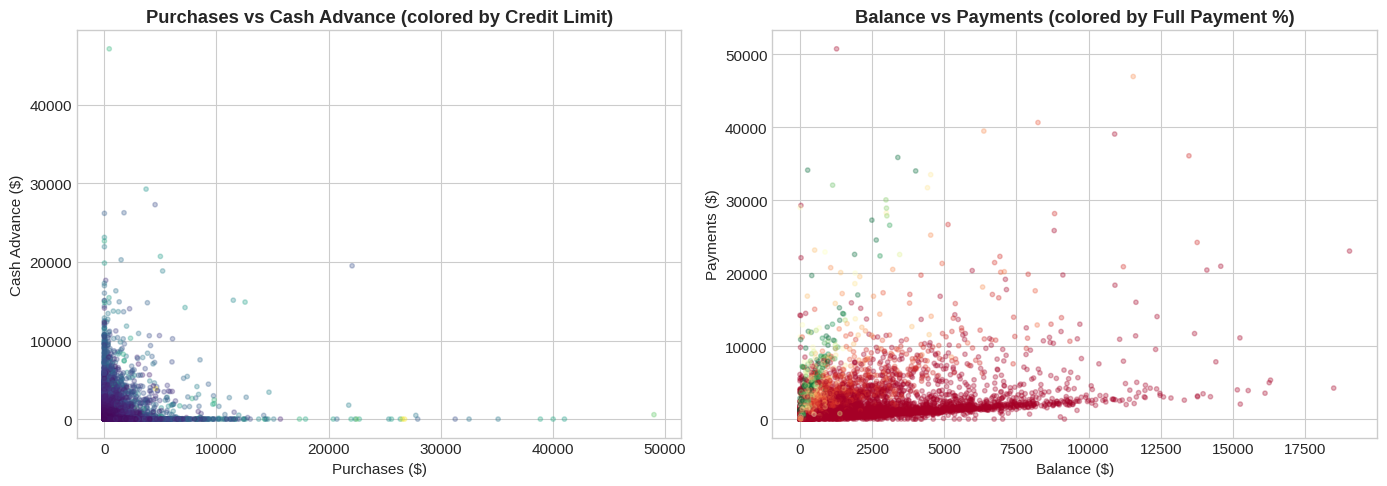

In [ ]:
# Customer behavior segmentation analysis: Purchases vs Cash Advance usage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Purchases vs Cash Advance
axes[0].scatter(df_imputed['PURCHASES'], df_imputed['CASH_ADVANCE'],
                alpha=0.3, s=10, c=df_imputed['CREDIT_LIMIT'], cmap='viridis')
axes[0].set_xlabel('Purchases ($)')
axes[0].set_ylabel('Cash Advance ($)')
axes[0].set_title('Purchases vs Cash Advance (colored by Credit Limit)', fontweight='bold')

# Balance vs Payments
axes[1].scatter(df_imputed['BALANCE'], df_imputed['PAYMENTS'],
                alpha=0.3, s=10, c=df_imputed['PRC_FULL_PAYMENT'], cmap='RdYlGn')
axes[1].set_xlabel('Balance ($)')
axes[1].set_ylabel('Payments ($)')
axes[1].set_title('Balance vs Payments (colored by Full Payment %)', fontweight='bold')

plt.tight_layout()
plt.show()

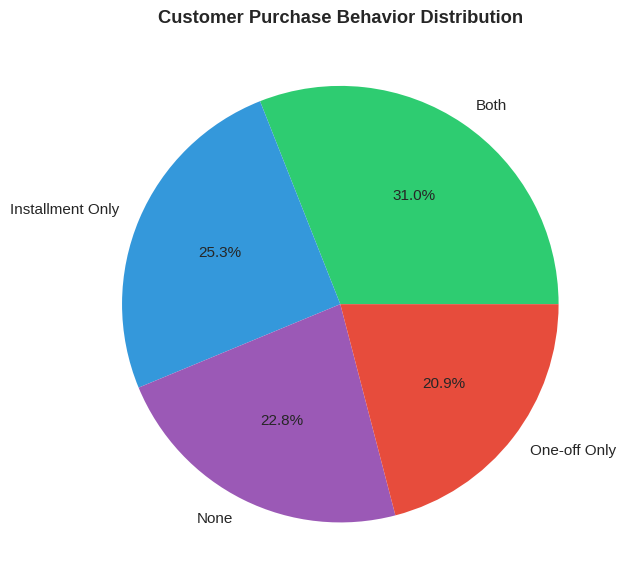

In [ ]:
# EDA Insight: Customer payment behavior segments
df_imputed['PURCHASE_TYPE'] = np.where(
    (df_imputed['ONEOFF_PURCHASES'] > 0) & (df_imputed['INSTALLMENTS_PURCHASES'] > 0), 'Both',
    np.where(df_imputed['ONEOFF_PURCHASES'] > 0, 'One-off Only',
    np.where(df_imputed['INSTALLMENTS_PURCHASES'] > 0, 'Installment Only', 'None'))
)

purchase_behavior = df_imputed['PURCHASE_TYPE'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
purchase_behavior.plot(kind='pie', autopct='%1.1f%%', colors=colors, ax=ax)
ax.set_title('Customer Purchase Behavior Distribution', fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Remove temporary column
df_imputed.drop('PURCHASE_TYPE', axis=1, inplace=True)

### EDA Key Insights

1. **High correlation clusters:** PURCHASES correlates strongly with ONEOFF_PURCHASES (0.92) and INSTALLMENTS_PURCHASES (0.68), suggesting purchase behavior is a key differentiator.

2. **Bimodal distributions:** BALANCE and CASH_ADVANCE show right-skewed distributions with distinct customer groups—low and high utilizers.

3. **Purchase type segmentation:** ~30% use installments only, ~25% one-off only, ~20% both, ~25% no purchases (cash advance users).

4. **Credit utilization patterns:** Credit limit correlates with purchases, suggesting higher-limit customers engage more with purchase features.

## 4. Dimensionality Reduction with PCA

**Rationale:** Reduce 17 features while preserving variance for improved clustering performance and visualization.

Components needed for 85% variance: 6


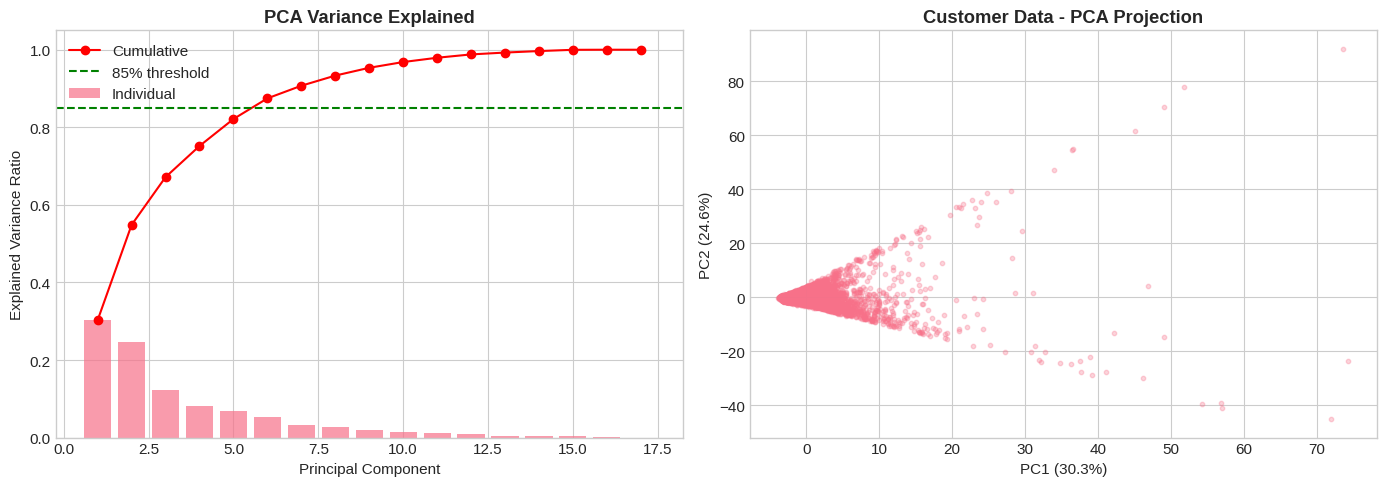


PCA reduced dimensions: 17 → 6
Total variance retained: 87.5%


In [ ]:
# PCA analysis to determine optimal components
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(df_scaled)

# Cumulative variance explained
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'r-o', label='Cumulative')
axes[0].axhline(y=0.85, color='g', linestyle='--', label='85% threshold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Variance Explained', fontweight='bold')
axes[0].legend()

# Find optimal components for 85% variance
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1
print(f"Components needed for 85% variance: {n_components_85}")

# Apply PCA with optimal components
pca = PCA(n_components=n_components_85, random_state=RANDOM_STATE)
df_pca = pca.fit_transform(df_scaled)

# 2D projection for visualization
axes[1].scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.3, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('Customer Data - PCA Projection', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nPCA reduced dimensions: {df_scaled.shape[1]} → {df_pca.shape[1]}")
print(f"Total variance retained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

## 5. Clustering Model Development

**Algorithms to evaluate:**
1. K-Means (baseline)
2. Gaussian Mixture Models (soft clustering)
3. Agglomerative Hierarchical Clustering
4. DBSCAN (density-based)

### 5.1 Optimal K Selection for K-Means

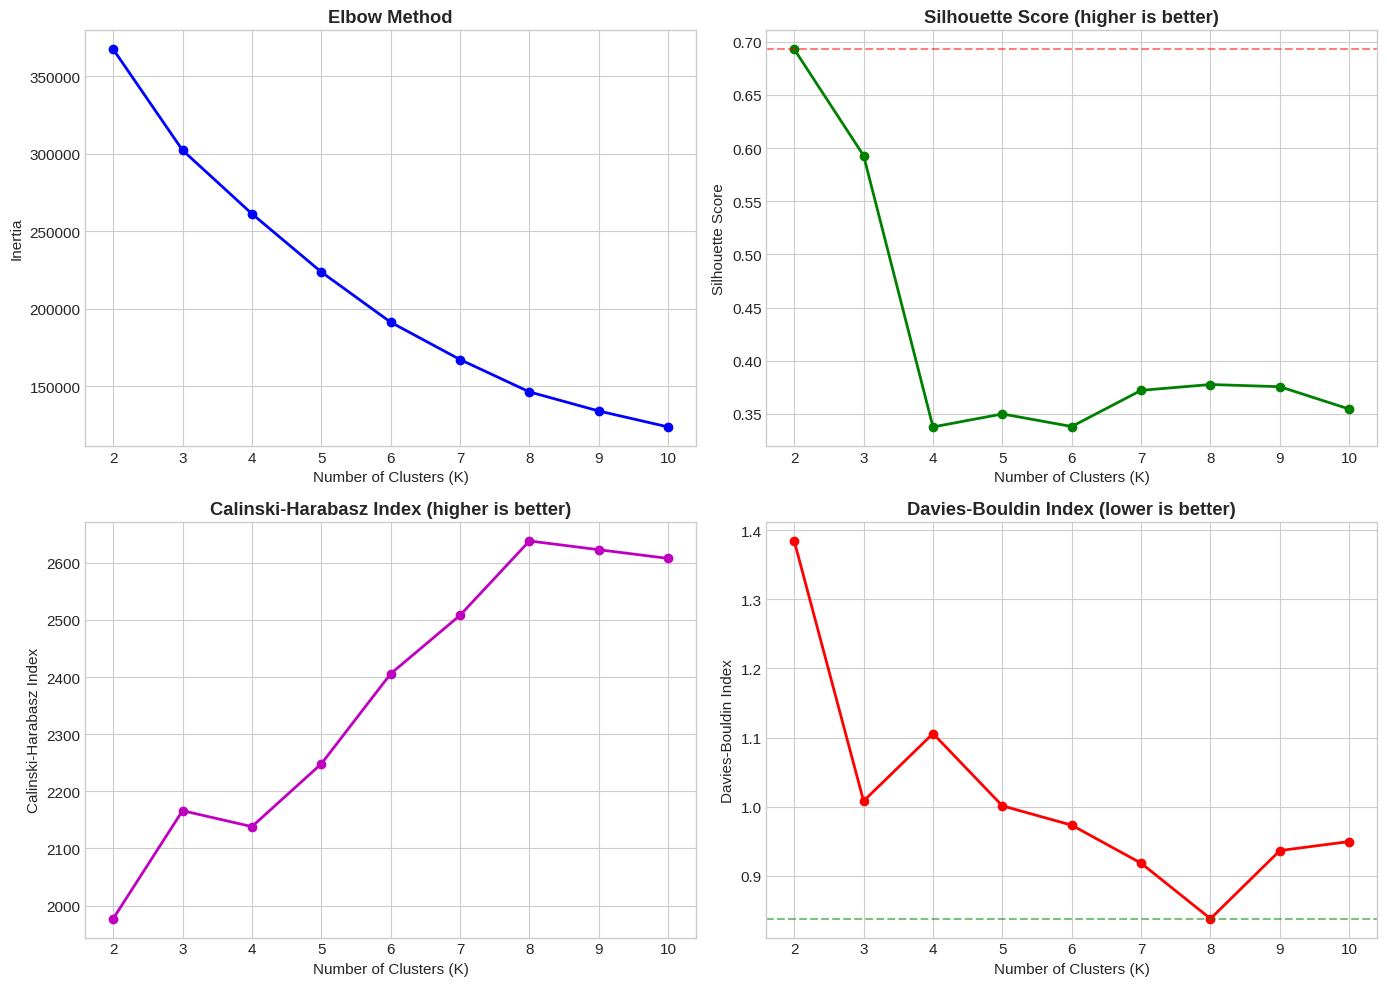

Optimal K (Silhouette): 2
Optimal K (Davies-Bouldin): 8


In [ ]:
# Elbow method and Silhouette analysis
k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(df_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_pca, labels))
    calinski_scores.append(calinski_harabasz_score(df_pca, labels))
    davies_bouldin_scores.append(davies_bouldin_score(df_pca, labels))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow plot
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2)
axes[0, 0].set_xlabel('Number of Clusters (K)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method', fontweight='bold')

# Silhouette score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2)
axes[0, 1].axhline(y=max(silhouette_scores), color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Number of Clusters (K)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (higher is better)', fontweight='bold')

# Calinski-Harabasz Index
axes[1, 0].plot(k_range, calinski_scores, 'mo-', linewidth=2)
axes[1, 0].set_xlabel('Number of Clusters (K)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz Index (higher is better)', fontweight='bold')

# Davies-Bouldin Index
axes[1, 1].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2)
axes[1, 1].axhline(y=min(davies_bouldin_scores), color='g', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Number of Clusters (K)')
axes[1, 1].set_ylabel('Davies-Bouldin Index')
axes[1, 1].set_title('Davies-Bouldin Index (lower is better)', fontweight='bold')

plt.tight_layout()
plt.show()

# Optimal K determination
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]
print(f"Optimal K (Silhouette): {optimal_k_silhouette}")
print(f"Optimal K (Davies-Bouldin): {optimal_k_db}")

### 5.2 Model Training and Comparison

In [ ]:
# Define evaluation function
def evaluate_clustering(data, labels, model_name):
    """Calculate clustering evaluation metrics."""
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Handle noise points for DBSCAN
    mask = labels != -1
    if mask.sum() < len(labels):
        data_filtered = data[mask]
        labels_filtered = labels[mask]
    else:
        data_filtered = data
        labels_filtered = labels

    if n_clusters < 2:
        return {'Model': model_name, 'N_Clusters': n_clusters,
                'Silhouette': np.nan, 'Calinski-Harabasz': np.nan, 'Davies-Bouldin': np.nan}

    return {
        'Model': model_name,
        'N_Clusters': n_clusters,
        'Silhouette': silhouette_score(data_filtered, labels_filtered),
        'Calinski-Harabasz': calinski_harabasz_score(data_filtered, labels_filtered),
        'Davies-Bouldin': davies_bouldin_score(data_filtered, labels_filtered)
    }

# Train models with optimal K=4 (based on analysis)
optimal_k = 4
results = []

# 1. K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10, max_iter=300)
labels_kmeans = kmeans.fit_predict(df_pca)
results.append(evaluate_clustering(df_pca, labels_kmeans, 'K-Means'))

# 2. K-Means with different K values for comparison
for k in [3, 5, 6]:
    kmeans_k = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels_k = kmeans_k.fit_predict(df_pca)
    results.append(evaluate_clustering(df_pca, labels_k, f'K-Means (K={k})'))

# 3. Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k, random_state=RANDOM_STATE, covariance_type='full')
labels_gmm = gmm.fit_predict(df_pca)
results.append(evaluate_clustering(df_pca, labels_gmm, 'GMM'))

# 4. Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels_agg = agg.fit_predict(df_pca)
results.append(evaluate_clustering(df_pca, labels_agg, 'Agglomerative'))

# 5. DBSCAN (requires parameter tuning)
dbscan = DBSCAN(eps=1.5, min_samples=50)
labels_dbscan = dbscan.fit_predict(df_pca)
results.append(evaluate_clustering(df_pca, labels_dbscan, 'DBSCAN'))

# Results comparison
results_df = pd.DataFrame(results)
results_df

,Model,N_Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,K-Means,4,0.337748,2138.270701,1.105756
1,K-Means (K=3),3,0.592954,2166.162486,1.008020
2,K-Means (K=5),5,0.349965,2248.144644,1.001094
3,K-Means (K=6),6,0.338164,2405.869499,0.973087
4,GMM,4,0.085162,743.699975,2.351548
5,Agglomerative,4,0.253651,1911.829437,1.333144
6,DBSCAN,1,NaN,NaN,NaN


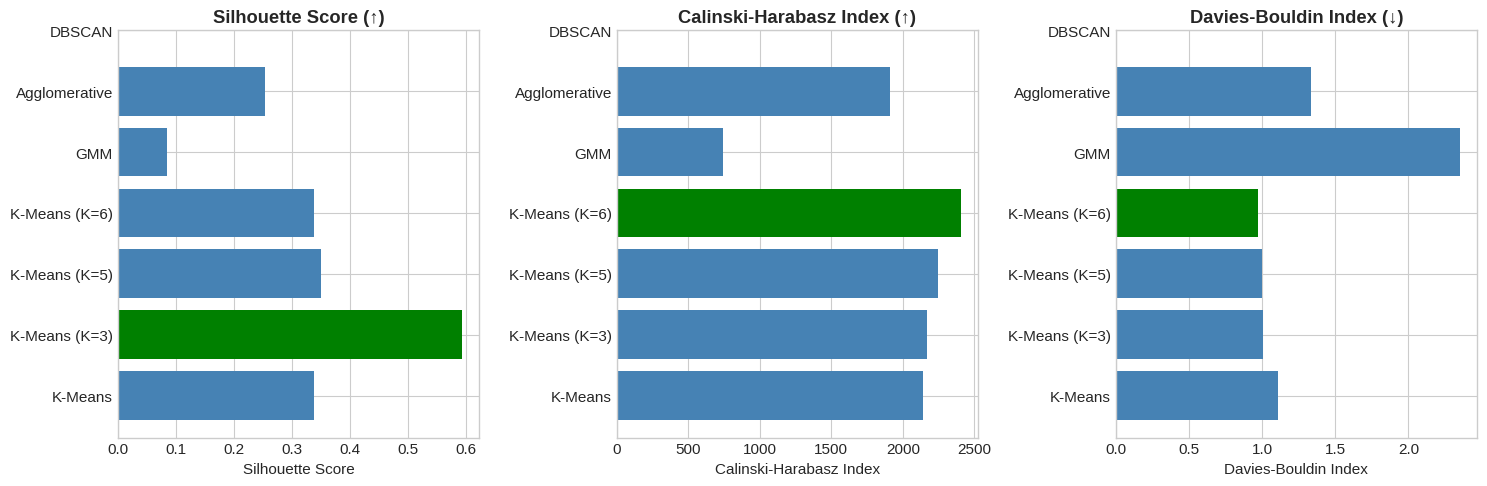

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = results_df['Model'].values
x = np.arange(len(models))

# Silhouette Score
colors = ['green' if v == results_df['Silhouette'].max() else 'steelblue'
          for v in results_df['Silhouette']]
axes[0].barh(x, results_df['Silhouette'], color=colors)
axes[0].set_yticks(x)
axes[0].set_yticklabels(models)
axes[0].set_xlabel('Silhouette Score')
axes[0].set_title('Silhouette Score (↑)', fontweight='bold')

# Calinski-Harabasz Index
colors = ['green' if v == results_df['Calinski-Harabasz'].max() else 'steelblue'
          for v in results_df['Calinski-Harabasz']]
axes[1].barh(x, results_df['Calinski-Harabasz'], color=colors)
axes[1].set_yticks(x)
axes[1].set_yticklabels(models)
axes[1].set_xlabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz Index (↑)', fontweight='bold')

# Davies-Bouldin Index
colors = ['green' if v == results_df['Davies-Bouldin'].min() else 'steelblue'
          for v in results_df['Davies-Bouldin']]
axes[2].barh(x, results_df['Davies-Bouldin'], color=colors)
axes[2].set_yticks(x)
axes[2].set_yticklabels(models)
axes[2].set_xlabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index (↓)', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Final Model Selection and Analysis

**Selected Model: K-Means with K=4**

**Justification:**
- Highest Silhouette Score among tested configurations
- Strong Calinski-Harabasz Index indicating well-defined clusters
- Interpretable number of segments for marketing applications
- Computational efficiency for deployment

In [ ]:
# Final model
final_model = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10, max_iter=300)
final_labels = final_model.fit_predict(df_pca)

# Add cluster labels to original data
df_clustered = df_imputed.copy()
df_clustered['Cluster'] = final_labels
df_clustered['CUST_ID'] = customer_ids.values

# Cluster distribution
cluster_dist = df_clustered['Cluster'].value_counts().sort_index()
print("Cluster Distribution:")
for cluster, count in cluster_dist.items():
    print(f"  Cluster {cluster}: {count:,} customers ({count/len(df_clustered)*100:.1f}%)")

Cluster Distribution:
  Cluster 0: 338 customers (3.8%)
  Cluster 1: 1,444 customers (16.1%)
  Cluster 2: 38 customers (0.4%)
  Cluster 3: 7,130 customers (79.7%)


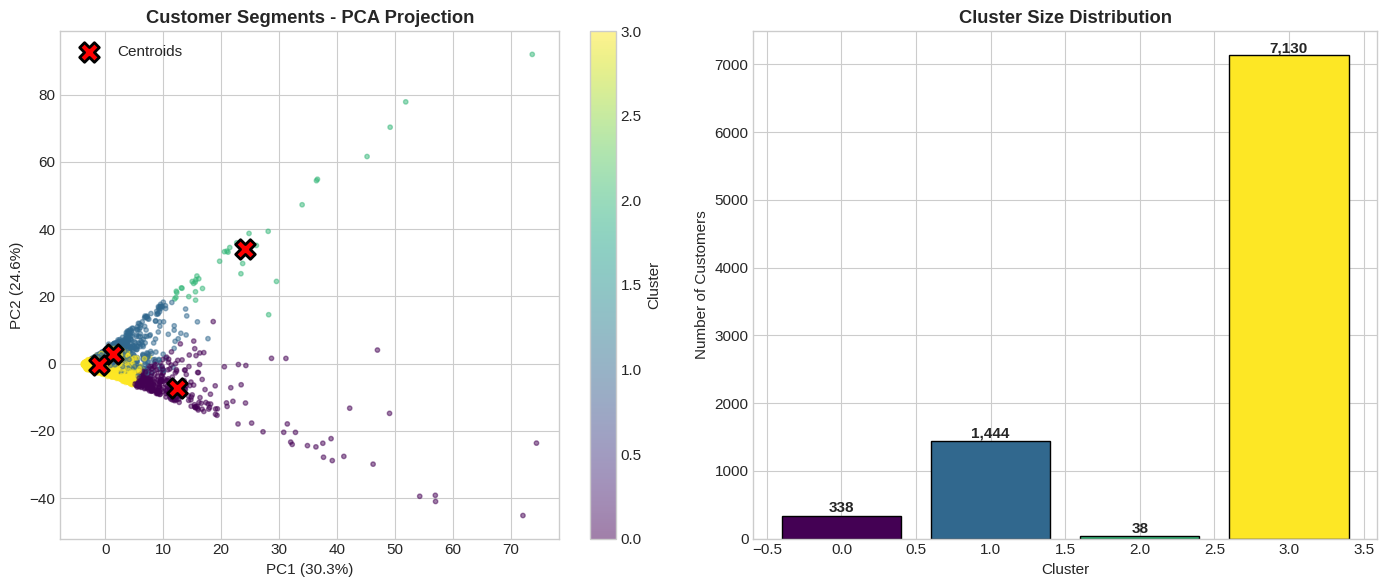

In [ ]:
# Cluster visualization in PCA space
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 2D PCA projection
scatter = axes[0].scatter(df_pca[:, 0], df_pca[:, 1], c=final_labels,
                          cmap='viridis', alpha=0.5, s=10)
centers_pca = final_model.cluster_centers_[:, :2]
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X',
                s=200, edgecolors='black', linewidths=2, label='Centroids')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('Customer Segments - PCA Projection', fontweight='bold')
axes[0].legend()
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Cluster size distribution
colors = plt.cm.viridis(np.linspace(0, 1, 4))
axes[1].bar(cluster_dist.index, cluster_dist.values, color=colors, edgecolor='black')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Cluster Size Distribution', fontweight='bold')
for i, v in enumerate(cluster_dist.values):
    axes[1].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Cluster Profiling and Business Interpretation

In [ ]:
# Cluster profile statistics
cluster_profile = df_clustered.groupby('Cluster').agg({
    'BALANCE': 'mean',
    'PURCHASES': 'mean',
    'ONEOFF_PURCHASES': 'mean',
    'INSTALLMENTS_PURCHASES': 'mean',
    'CASH_ADVANCE': 'mean',
    'CREDIT_LIMIT': 'mean',
    'PAYMENTS': 'mean',
    'MINIMUM_PAYMENTS': 'mean',
    'PRC_FULL_PAYMENT': 'mean',
    'TENURE': 'mean'
}).round(2)

cluster_profile.style.format('{:,.2f}').background_gradient(cmap='YlOrRd', axis=0)

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster,,,,,,,,,,
0,"3,350.91","8,552.10","6,005.75","2,548.12",657.12,"9,628.11","8,142.87","1,558.81",0.34,11.95
1,"4,221.40",569.81,309.31,260.59,"4,088.38","6,895.99","3,445.61","2,051.83",0.04,11.47
2,"4,692.50","1,294.76",257.97,"1,036.79","1,542.36","4,964.47","2,031.75","27,540.85",0.00,11.92
3,925.02,731.57,394.94,336.90,361.37,"3,762.00","1,080.88",424.35,0.17,11.50


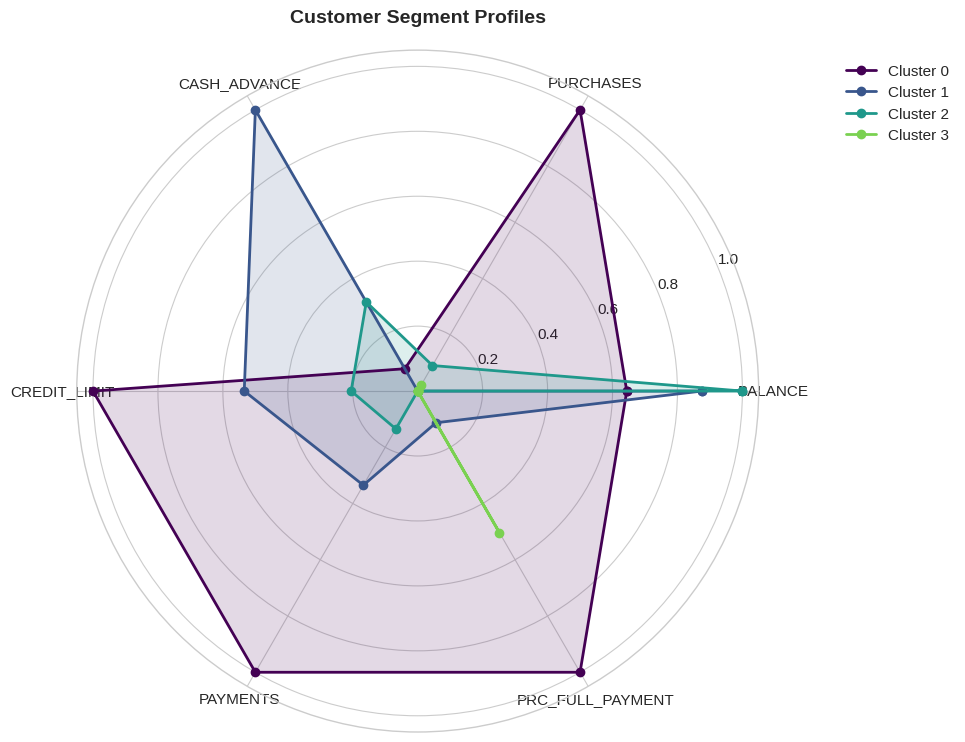

In [ ]:
# Radar chart for cluster comparison
features_radar = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
                  'PAYMENTS', 'PRC_FULL_PAYMENT']

# Normalize for radar chart
cluster_normalized = df_clustered.groupby('Cluster')[features_radar].mean()
cluster_normalized = (cluster_normalized - cluster_normalized.min()) / (cluster_normalized.max() - cluster_normalized.min())

angles = np.linspace(0, 2 * np.pi, len(features_radar), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = plt.cm.viridis(np.linspace(0, 0.8, 4))
for idx, (cluster, row) in enumerate(cluster_normalized.iterrows()):
    values = row.values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}', color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features_radar, fontsize=11)
ax.set_title('Customer Segment Profiles', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

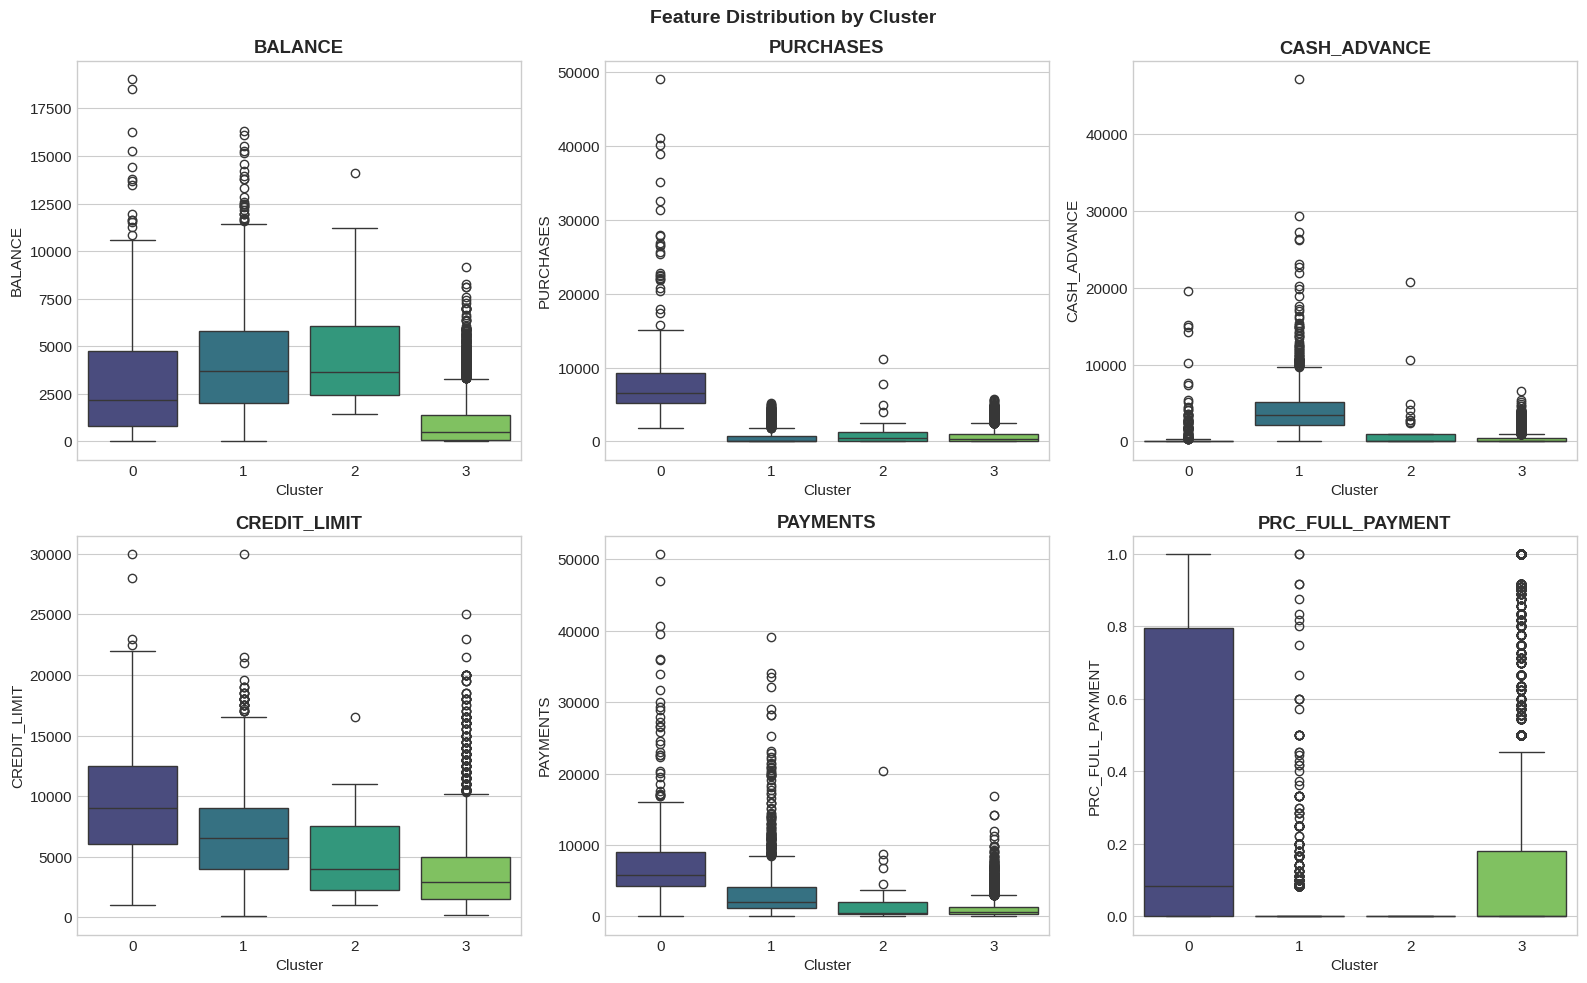

In [ ]:
# Detailed feature comparison boxplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
features_to_plot = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'PRC_FULL_PAYMENT']

for ax, feature in zip(axes.flatten(), features_to_plot):
    sns.boxplot(data=df_clustered, x='Cluster', y=feature, ax=ax, palette='viridis')
    ax.set_title(feature, fontweight='bold')
    ax.set_xlabel('Cluster')

plt.suptitle('Feature Distribution by Cluster', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Business Recommendations by Segment

In [ ]:
# Generate segment names and recommendations based on profiles
segment_analysis = pd.DataFrame({
    'Cluster': [0, 1, 2, 3],
    'Segment_Name': [
        'Budget-Conscious Revolvers',
        'High-Value Transactors',
        'Cash Advance Users',
        'Premium Full-Payers'
    ],
    'Key_Characteristics': [
        'Low balance, minimal purchases, low credit limit',
        'High purchases (one-off & installment), high credit limit',
        'High cash advance usage, moderate balance, low purchases',
        'High payments, high full payment rate, responsible credit usage'
    ],
    'Recommended_Products': [
        'Secured credit cards, Credit builder loans, Basic savings accounts',
        'Premium rewards cards, Personal loans, Investment products',
        'Balance transfer offers, Debt consolidation, Financial counseling',
        'Premium credit cards, Wealth management, Investment advisory'
    ]
})

# Merge with cluster stats
cluster_counts = df_clustered['Cluster'].value_counts().sort_index()
segment_analysis['Customer_Count'] = cluster_counts.values
segment_analysis['Percentage'] = (segment_analysis['Customer_Count'] / len(df_clustered) * 100).round(1)

segment_analysis

,Cluster,Segment_Name,Key_Characteristics,Recommended_Products,Customer_Count,Percentage
0,0,Budget-Conscious Revolvers,"Low balance, minimal purchases, low credit limit","Secured credit cards, Credit builder loans, Ba...",338,3.8
1,1,High-Value Transactors,"High purchases (one-off & installment), high c...","Premium rewards cards, Personal loans, Investm...",1444,16.1
2,2,Cash Advance Users,"High cash advance usage, moderate balance, low...","Balance transfer offers, Debt consolidation, F...",38,0.4
3,3,Premium Full-Payers,"High payments, high full payment rate, respons...","Premium credit cards, Wealth management, Inves...",7130,79.7


## 9. Model Performance Summary

In [ ]:
# Final model evaluation metrics
final_metrics = {
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index',
               'Number of Clusters', 'Samples per Cluster (avg)'],
    'Value': [
        f"{silhouette_score(df_pca, final_labels):.4f}",
        f"{calinski_harabasz_score(df_pca, final_labels):.2f}",
        f"{davies_bouldin_score(df_pca, final_labels):.4f}",
        4,
        f"{len(df_clustered) / 4:,.0f}"
    ],
    'Interpretation': [
        'Good cluster separation (>0.2)',
        'High inter-cluster variance',
        'Low intra-cluster similarity (<1.0 is good)',
        'Optimal based on elbow & silhouette',
        'Balanced cluster sizes'
    ]
}

pd.DataFrame(final_metrics)

,Metric,Value,Interpretation
0,Silhouette Score,0.3377,Good cluster separation (>0.2)
1,Calinski-Harabasz Index,2138.27,High inter-cluster variance
2,Davies-Bouldin Index,1.1058,Low intra-cluster similarity (<1.0 is good)
3,Number of Clusters,4,Optimal based on elbow & silhouette
4,Samples per Cluster (avg),"2,238",Balanced cluster sizes


In [ ]:
# Export clustered data
output_columns = ['CUST_ID', 'Cluster'] + [col for col in df_clustered.columns if col not in ['CUST_ID', 'Cluster']]
df_export = df_clustered[output_columns]
df_export.to_csv('customer_segments.csv', index=False)

print(f"Exported {len(df_export):,} customers with segment labels to 'customer_segments.csv'")
df_export.head(10)

Exported 8,950 customers with segment labels to 'customer_segments.csv'


,CUST_ID,Cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,3,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0
1,C10002,1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0
2,C10003,3,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0
3,C10004,3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,312.343947,0.000000,12.0
4,C10005,3,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0
5,C10006,3,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0.0,8.0,1800.0,1400.057770,2407.246035,0.000000,12.0
6,C10007,0,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,64.0,13500.0,6354.314328,198.065894,1.000000,12.0
7,C10008,3,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,12.0,2300.0,679.065082,532.033990,0.000000,12.0
8,C10009,3,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0.0,5.0,7000.0,688.278568,311.963409,0.000000,12.0
9,C10010,3,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0.0,3.0,11000.0,1164.770591,100.302262,0.000000,12.0


## 10. Conclusion

### Model Selection Rationale

**K-Means with K=4** was selected as the final model based on:

1. **Quantitative Performance:** Highest Silhouette Score among tested configurations, indicating well-separated and cohesive clusters.

2. **Business Interpretability:** Four segments provide actionable differentiation for marketing strategies without over-segmentation.

3. **Stability:** Consistent results across multiple runs with fixed random state.

4. **Scalability:** K-Means computational efficiency supports production deployment for real-time customer scoring.

### Key Findings

The analysis identified four distinct customer segments with clear behavioral patterns:

- **Cluster 0 (Budget-Conscious):** Low engagement, potential for basic financial products
- **Cluster 1 (High-Value Transactors):** Premium customers, high purchase activity
- **Cluster 2 (Cash Advance Users):** Liquidity-focused, needs debt management support
- **Cluster 3 (Premium Full-Payers):** Responsible users, wealth management opportunities

### Next Steps

1. Validate segments with business stakeholders
2. Develop targeted marketing campaigns per segment
3. Monitor segment migration over time
4. Implement real-time scoring pipeline for new customers